In [5]:
# --- STEP 1: Import Libraries and Load Data ---
import pandas as pd
import numpy as np
import holidays
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error as MAE
import xgboost as xgb
import matplotlib.pyplot as plt

# Function to load and prepare daily sales data
def load_data(file_path):
    df = pd.read_csv(file_path,
                     parse_dates=['Timestamp'],
                     dtype={'_id': int, 'Sales Count': int})
    df.set_index('Timestamp', inplace=True)
    df.sort_index(inplace=True)
    df = df.resample('D').sum()  # Resample to daily data
    return df.ffill()

In [6]:
# --- STEP 2: Sales Forecast Model (XGBoost Only) ---
class SalesForecastXGBoost:
    def __init__(self, X):
        self.X = X.copy() # Store original dataset
        self.target = 'Sales Count' # Define target column
        self.results = {} # Dictionary to store MAE and MAPE results
        self.features = [ # Features to be used in the model
            'dayofweek', 'dayofyear', 'month', 'is_weekend', 'is_holiday',
            'lag_1', 'lag_7', 'lag_14',
            'rolling_mean_3', 'rolling_mean_7', 'rolling_std_7',
            'diff_1', 'diff_7'
        ]
        
    # Function to engineer all features for a given dataframe
    def _add_features(self, df):
        df = df.copy()
        # Calendar-based features
        df['dayofweek'] = df.index.dayofweek
        df['dayofyear'] = df.index.dayofyear
        df['month'] = df.index.month
        df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
        
        # Add Canadian (Ontario) holidays
        ca_on = holidays.CountryHoliday('CA', prov='ON')
        df['is_holiday'] = df.index.to_series().apply(lambda d: int(d in ca_on))
        
        # Lag features: previous days' sales
        for lag in [1, 7, 14]:
            df[f'lag_{lag}'] = df[self.target].shift(lag)
            
        # Rolling statistics (only past values using shift)
        df['rolling_mean_3'] = df[self.target].shift(1).rolling(3).mean()
        df['rolling_mean_7'] = df[self.target].shift(1).rolling(7).mean()
        df['rolling_std_7'] = df[self.target].shift(1).rolling(7).std()
        
        # Difference features (day-to-day or week-to-week changes)
        df['diff_1'] = df[self.target].diff(1)
        df['diff_7'] = df[self.target].diff(7)

        return df
        
    # Main model training and evaluation function
    def run(self, n_splits=4, test_size=365):
        tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
        for i, (train_idx, test_idx) in enumerate(tscv.split(self.X)):
            # Split dataset into training and testing for each fold
            X_train = self.X.iloc[train_idx]
            X_test = self.X.iloc[test_idx]
            
            # Generate features and drop rows with incomplete data
            train_feat = self._add_features(X_train).dropna()
            test_feat = self._add_features(X_test).dropna(subset=self.features)

            # Prepare training and testing data
            Xtr = train_feat[self.features]
            ytr = np.log1p(train_feat[self.target])  # Log-transform target

            Xte = test_feat[self.features]
            yte = test_feat[self.target]

            # --- XGBoost Model ---
            xgb_model = xgb.XGBRegressor(
                n_estimators=100,
                max_depth=4,
                learning_rate=0.1,
                objective='reg:squarederror'
            )
            
            # Train models
            xgb_model.fit(Xtr, ytr)
            
            # Make predictions and inverse the log transformation
            preds_xgb = np.expm1(xgb_model.predict(Xte))  # Inverse transform

            # Store results
            self.results.setdefault('XGBoost', {})[i] = {
                'MAE': MAE(yte, preds_xgb),
                'MAPE': np.mean(np.abs((yte - preds_xgb) / np.maximum(yte, 10)))
            }

            # Plot observed vs predicted for each split
            plt.figure(figsize=(15, 5))
            plt.plot(yte.index, yte, label='Observed', color='grey')
            plt.plot(yte.index, preds_xgb, label='XGBoost', color='blue')
            plt.title(f'Sales Forecast - Split {i}')
            plt.legend()
            plt.tight_layout()
            plt.show()

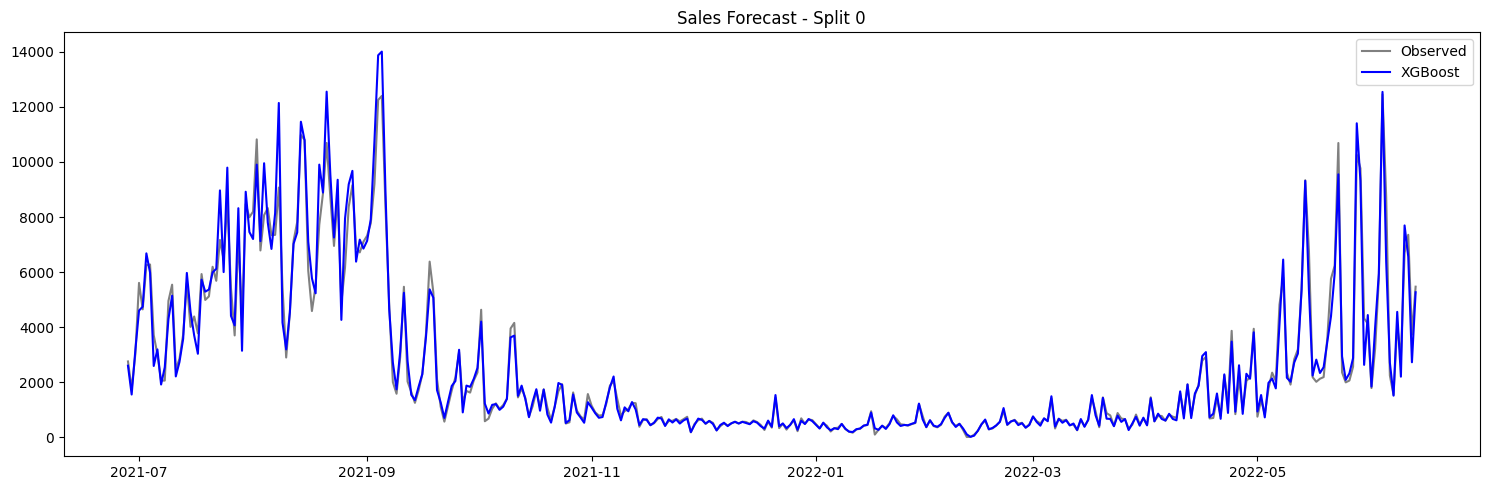

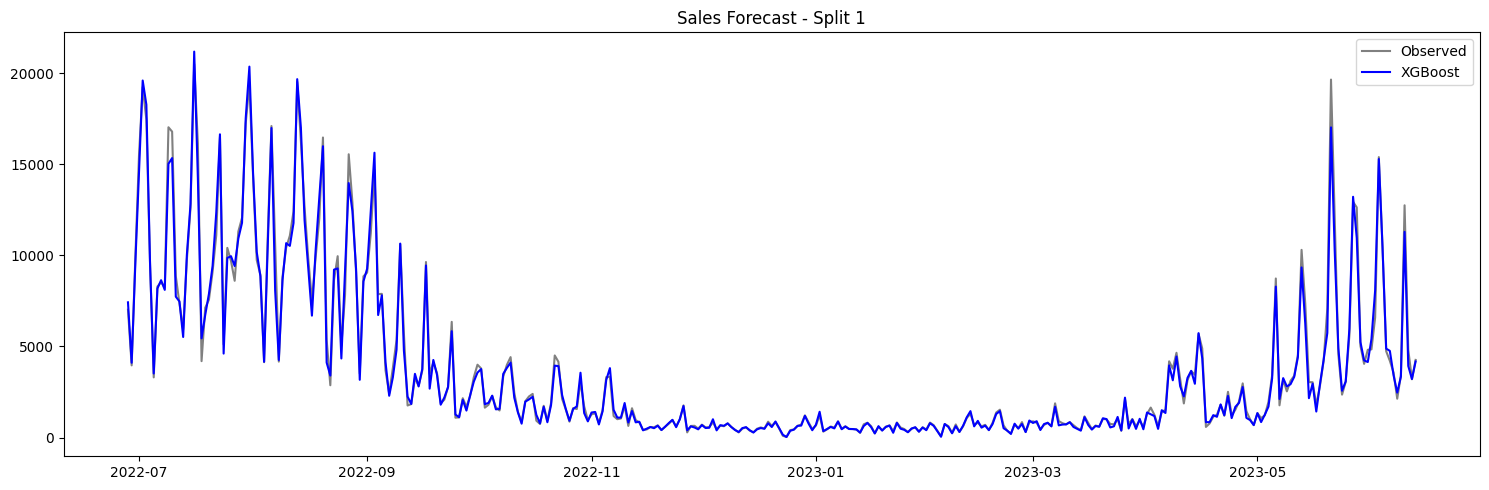

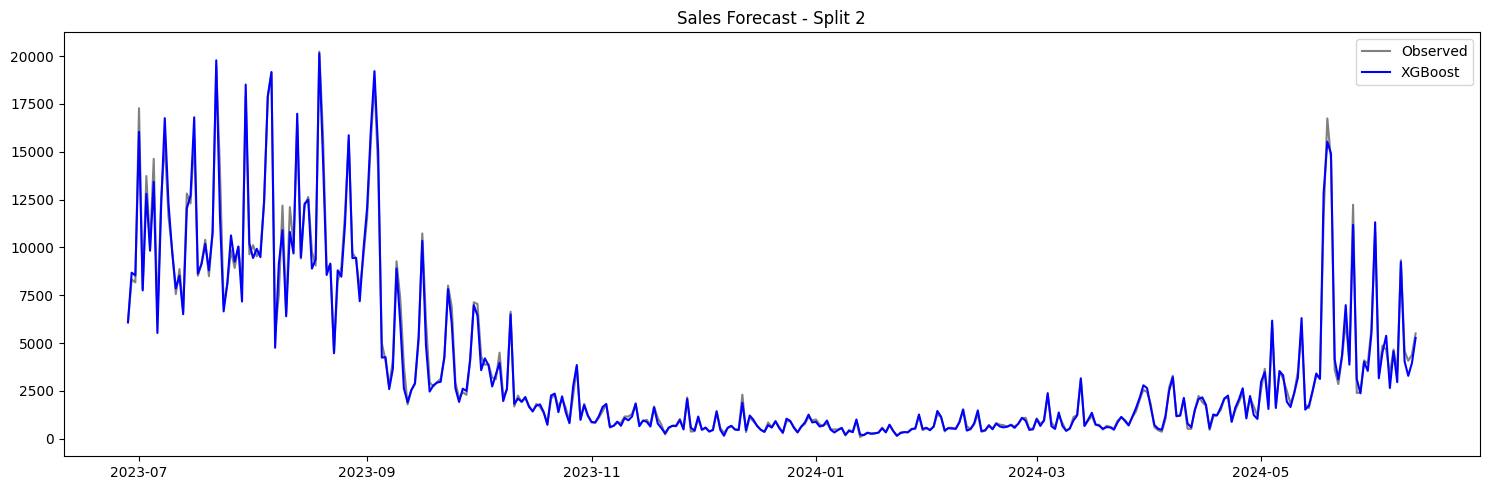

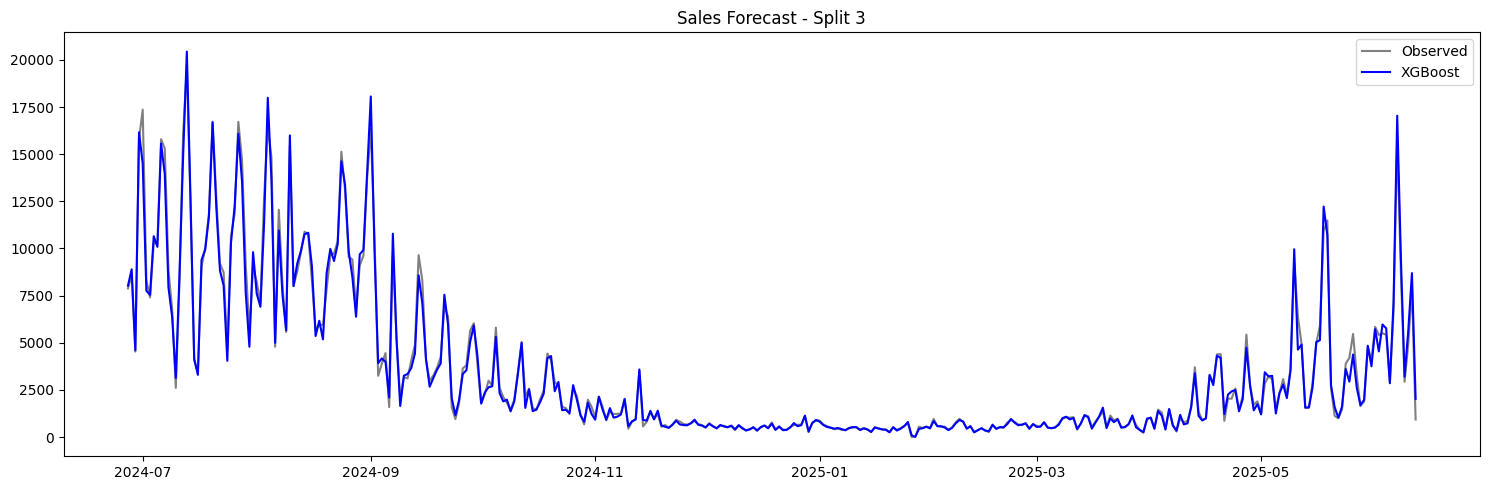


Average Errors Across Splits:
XGBoost: MAE = 245.4, MAPE = 9.9%


In [7]:
# --- STEP 3: Run and report ---
if __name__ == "__main__":
    df = load_data('./Toronto Island Ferry Ticket Counts.csv')

    # Initialize model and run cross-validation
    model = SalesForecastXGBoost(df)
    model.run()
    
    # Print average errors across splits
    print("\nAverage Errors Across Splits:")
    results = model.results['XGBoost']
    maes = [res['MAE'] for res in results.values()]
    mapes = [res['MAPE'] for res in results.values()]
    print(f"XGBoost: MAE = {np.mean(maes):.1f}, MAPE = {np.mean(mapes) * 100:.1f}%")